In this notebook, we determine what fraction of events of a particular reaction have muon that enters the detector,
making the simplifying assumption that there is a uniform distribution of the particles' kinematics in the available phase space.
The reaction is $e p \rightarrow e'D_0\Lambda_c^+$ followed by $\Lambda_c^+\rightarrow\Lambda^0\bar\nu_\mu\mu^+$.  In principle,
the code used in this simplified event generator could be used for other reactions as well.  

The generation of three-particle events follows Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 .  

In [96]:
import ROOT, numpy as np, random, pandas as pd
rand = random.Random()
import matplotlib as mpl, matplotlib.pylab as plt, matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [7.00, 5.00]
#presets for plot style
rc = plt.rc
rc('text', usetex=False)
rc('font', family='serif')
rc('font', size=16)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('axes', labelsize=16)
rc('legend', fontsize=16)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

pdg = ROOT.TDatabasePDG()

Warning in <TDatabasePDG::TDatabasePDG>: object already instantiated


In [97]:
class oneToTwoGenerator():
    def __init__(self, m0, m1, m2):
        self.m1 = m1
        self.m2 = m2
        self.m0 = m0
        self.p = np.sqrt(m1**4+m2**4+m0**4-2*m1**2*m0**2-2*m1**2*m2**2-2*m0**2*m2**2)/(2*m0)
        self.E1 = np.hypot(m1, self.p) 
        self.E2 = np.hypot(m2, self.p)
    
    def next(self, P0):
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)
        
        p = self.p
        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, self.E1)
        P2 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, self.E2)
        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1,P2

 Use the formulas found here to get the 3-particle phase space:  Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 

In [98]:
class oneToThreeGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

In [99]:
#similar to the oneToThreeGenerator, except with a delta function on Q^2 = (P2-P0)^2, where P2 is the scattered electron
class PhotoproductionGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1024+2)[1:-1]
        
        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13 for non-photoproduction
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        #multiply by an additional factor of 1/p2_cm because of the delta function on Q2.
        p2 = (1-self.s13s)/2
        self.pdf/=p2
        
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0,search="binary"):
        
        #these are for particle 2:
        phi=0
        cosTheta=1 #electron is going in the forward direction, since Q^2 goes to zero
        sinTheta=0

        

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        if search == "linear":
            found=False
            for i in range(len(self.cdf)):
                if(self.cdf[i]>u):
                    s13=self.s13s[i]
                    found = True
                    break
            if not found:
                raise Exception("s13 not found in table")
        #perform binary search
        if search == "binary":
            i=512
            di=256
            while di >=1:
                if (u> self.cdf[i]):
                    i+=di
                else :
                    i -=di
                di=di//2
            s13=self.s13s[i]


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

### User Inputs and constants

In [100]:
Ebeam=10 #GeV

mp=.9383
mn=.9396
mD0=1.86484
mLambdaC=2.2849
mLambda=1.115683
me=0.000511
mMu=0.1057
mpi_charged = 0.1396
mpi0 = 0.1350
mK0=0.497611
mKshort=mK0
mK_charged=0.493677
mKstar = 0.89555
mrho0=0.77549
mrho_charged=0.77526
mSigma0=1.192642
mSigmaP=1.18937
mSigmaN=mSigmaP
meta=0.547862
metaprime=0.95778
momega=0.78266
mphi=1.019461

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

P0=ROOT.TLorentzVector(0, 0, Ebeam,Ebeam+mp)
#DIS Event Generator
#ep_to_d0_e_lambdac= oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
ep_to_d0_e_lambdac= PhotoproductionGenerator(P0.M(), mD0, me, mLambdaC)

#Decay generators; decays for the lambda_c taken from 
#https://pdglive.lbl.gov/Particle.action?init=0&node=S033&home=BXXX040
DecayChannels = []
BranchingRatios = []


#lambda_c -> muon + X modes
DecayChannels.append("$\\mu^+ \\Lambda \\rightarrow \\mu^+ p \\pi^-$")                      #0
DecayChannels.append("$\\mu^+ \\Lambda \\rightarrow \\mu^+ n \\pi^0$")                      #1
lambdac_to_lambdamu = oneToThreeGenerator(mLambdaC, mLambda, 0, mMu) #BR= 3.5e-2 +- 0.5e-2
f_lambdac_to_lambdamu = 0.035
f_lambdac_to_lambdamu_unc = 0.005
#secondary lambda decay
lambda_to_npi = oneToTwoGenerator(mLambda, mn, mpi0)
f_lambda_to_npi=.36
lambda_to_ppi = oneToTwoGenerator(mLambda, mp, mpi_charged)
f_lambda_to_ppi=.64
BranchingRatios.append(f_lambdac_to_lambdamu*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdamu*f_lambda_to_npi)

#lambda_c -> n + X modes
DecayChannels.append("$n \\pi^+ K^0_S \\rightarrow n \\pi^+ \\pi^+ \\pi^-$")                #2
DecayChannels.append("$n \\pi^+ K^0_S \\rightarrow n \\pi^+ \\pi^0 \\pi^0$")                #3
lambdac_to_nKspi = oneToThreeGenerator(mLambdaC, mn, mpi_charged, mKshort)
f_lambdac_to_nKspi = 0.0182
f_lambdac_to_nKspi_unc = 0.0025
#secondary K_s decay
Kshort_to_picharged = oneToTwoGenerator(mKshort,mpi_charged,mpi_charged)
f_Kshort_to_picharged = 0.692
f_Kshort_to_picharged_unc = 0.0005
Kshort_to_pi0 = oneToTwoGenerator(mKshort,mpi0,mpi0)
f_Kshort_to_pi0 = 0.307
f_Kshort_to_pi0_unc = 0.0005
BranchingRatios.append(f_lambdac_to_nKspi*f_Kshort_to_picharged)
BranchingRatios.append(f_lambdac_to_nKspi*f_Kshort_to_pi0)

#lambda_c -> p + X modes
DecayChannels.append("$p K^0_S \\rightarrow p \\pi^+ \\pi^-$")                              #4
DecayChannels.append("$p K^0_S \\rightarrow p \\pi^0 \\pi^0$")                              #5
lambdac_to_pKs = oneToTwoGenerator(mLambdaC, mp, mKshort)
f_lambdac_to_pKs = 0.0159
f_lambdac_to_pKs_unc = 0.0008
BranchingRatios.append(f_lambdac_to_pKs*f_Kshort_to_picharged)
BranchingRatios.append(f_lambdac_to_pKs*f_Kshort_to_pi0)

DecayChannels.append("$p K^- \\pi^+ (NR)$")                                                 #6
lambdac_to_pKpi = oneToThreeGenerator(mLambdaC, mp, mK_charged,mpi_charged)
f_lambdac_to_pKpi = 0.035
f_lambdac_to_pKpi_unc = 0.004
BranchingRatios.append(f_lambdac_to_pKpi)

DecayChannels.append("$p \\overline{K}^{*}\\left(892\\right)^0 \\rightarrow p K^+ \\pi^-$")                              #7
lambdac_to_pKstar = oneToTwoGenerator(mLambdaC, mp, mKstar)
f_lambdac_to_pKstar = 0.0196
f_lambdac_to_pKstar_unc = 0.0027
Kstar_to_kpi = oneToTwoGenerator(mKstar, mK_charged, mpi_charged) #unknown BRs to uncharged K/pi and charge conjugate but we don't care about the K/pi so much
f_Kstar_to_kpi=1
BranchingRatios.append(f_lambdac_to_pKstar)

DecayChannels.append("$p K^0_S \\pi^0 \\rightarrow p \\pi^+ \\pi^- \\pi^0$")                    #8
DecayChannels.append("$p K^0_S \\pi^0 \\rightarrow p \\pi^0 \\pi^0 \\pi^0$")                    #9
lambdac_to_pK0pi0 = oneToThreeGenerator(mLambdaC, mp, mKshort, mpi0)
f_lambdac_to_pK0pi0 = 0.0197
f_lambdac_to_pK0pi0_unc = 0.0013
BranchingRatios.append(f_lambdac_to_pK0pi0*f_Kshort_to_picharged)
BranchingRatios.append(f_lambdac_to_pK0pi0*f_Kshort_to_pi0)

#do we need to worry about the pions and kaons from the other particles which may be background for the D0 decay?
DecayChannels.append("$p \\overline{K}^0 \\eta \\rightarrow p K^0_L \\eta$")                    #10 -- the eta is treated as a final state particle for simplicity
DecayChannels.append("$p \\overline{K}^0 \\eta \\rightarrow p \\pi^+ \\pi^- \\eta$")            #11
DecayChannels.append("$p \\overline{K}^0 \\eta \\rightarrow p \\pi^0 \\pi^0 \\eta$")            #12
lambdac_to_pK0eta = oneToThreeGenerator(mLambdaC, mp, mK0, meta)
f_lambdac_to_pK0eta = 0.0083
f_lambdac_to_pK0eta_unc = 0.0018
f_K0_to_KS = 0.5  #the K0 is treated as decaying 50/50 to a K_S or K_L
f_K0_to_KL = 0.5
BranchingRatios.append(f_lambdac_to_pK0eta*f_K0_to_KL)
BranchingRatios.append(f_lambdac_to_pK0eta*f_K0_to_KS*f_Kshort_to_picharged)
BranchingRatios.append(f_lambdac_to_pK0eta*f_K0_to_KS*f_Kshort_to_pi0)

DecayChannels.append("$p K^* \\left(892\\right)^- \\pi^+ \\rightarrow p K^- \\pi^0 \\pi^+$")      #13 -- K892 only decays to K-pi0 - 
lambdac_to_pKstarpi = oneToThreeGenerator(mLambdaC, mp, mKstar, mpi_charged)
f_lambdac_to_pKstarpi = 0.014
f_lambdac_to_pKstarpi_unc = 0.005
KstarN_to_kpi0 = oneToTwoGenerator(mKstar, mK_charged, mpi0) #unknown BRs to uncharged K but we don't care about the K/pi so much
f_KstarN_to_kpi0=1
BranchingRatios.append(f_lambdac_to_pKstarpi)


#lambda -> n/p + X intermediate resonance
f_lambdac_lambda=.382 #inclusive lambda_c -> lambda + X
DecayChannels.append("$\\Lambda \\pi^+ \\rightarrow p \\pi^- \\pi^+$")                    #14
DecayChannels.append("$\\Lambda \\pi^+ \\rightarrow n \\pi^0 \\pi^+$")                    #15
lambdac_to_lambdapi = oneToTwoGenerator(mLambdaC, mLambda, mpi_charged) #BR= 1.3e-2 +- 0.07e-2
f_lambdac_to_lambdapi = 0.013
f_lambdac_to_lambdapi_unc = 0.0007
BranchingRatios.append(f_lambdac_to_lambdapi*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdapi*f_lambda_to_npi)

DecayChannels.append("$\\Lambda \\pi^+ \\pi^0 \\rightarrow p \\pi^- \\pi^+ \\pi^0$")       #16
DecayChannels.append("$\\Lambda \\pi^+ \\pi^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^0$")       #17
lambdac_to_lambdapipi0 = oneToThreeGenerator(mLambdaC, mLambda, mpi_charged, mpi0) #BR= 7.1e-2 +- 0.4e-2 (includes intermediate rho state, <6%)
f_lambdac_to_lambdapipi0 = 0.011
f_lambdac_to_lambdapipi0_unc = 0.004
BranchingRatios.append(f_lambdac_to_lambdapipi0*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdapipi0*f_lambda_to_npi)

DecayChannels.append("$\\Lambda \\rho^+ \\rightarrow p \\pi^- \\pi^+ \\pi^0$")             #18
DecayChannels.append("$\\Lambda \\rho^+ \\rightarrow n \\pi^0 \\pi^+ \\pi^0$")             #19
lambdac_to_lambdarho = oneToTwoGenerator(mLambdaC, mLambda, mrho_charged) #BR= 7.1e-2 +- 0.4e-2 (includes intermediate rho state, <6%)
f_lambdac_to_lambdarho = 0.06
f_lambdac_to_lambdarho_unc = 0.03
#secondary rho_charged decay
rho_to_pipi0 = oneToTwoGenerator(mrho_charged, mpi0, mpi_charged)
f_rho_to_pipi0=.995
BranchingRatios.append(f_lambdac_to_lambdarho*f_rho_to_pipi0*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdarho*f_rho_to_pipi0*f_lambda_to_npi)

DecayChannels.append("$\\Lambda  \\pi^+ \\rho^0 \\rightarrow p \\pi^- \\pi^+ \\pi^+ \\pi^-$")  #20
DecayChannels.append("$\\Lambda \\pi^+ \\rho^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^+ \\pi^-$")   #21
lambdac_to_lambdarhopi = oneToThreeGenerator(mLambdaC, mLambda, mrho0, mpi_charged)
f_lambdac_to_lambdarhopi = 0.015
f_lambdac_to_lambdarhopi_unc = 0.006
#secondary rho_0 decay
rho_to_pipi = oneToTwoGenerator(mrho0, mpi_charged, mpi_charged)
f_rho_to_pipi=.99
BranchingRatios.append(f_lambdac_to_lambdarhopi*f_rho_to_pipi*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdarhopi*f_rho_to_pipi*f_lambda_to_npi)

DecayChannels.append("$\\Lambda  \\pi^+ \\eta \\rightarrow p \\pi^- \\pi^+ \\eta$")  #22  -- the eta is treated as a final state particle for simplicity
DecayChannels.append("$\\Lambda \\pi^+ \\eta \\rightarrow n \\pi^0 \\pi^+ \\eta$")   #23
lambdac_to_lambdapieta = oneToThreeGenerator(mLambdaC, mLambda, mpi_charged, meta)
f_lambdac_to_lambdapieta = 0.0093
f_lambdac_to_lambdapieta_unc = 0.0033
BranchingRatios.append(f_lambdac_to_lambdapieta*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdapieta*f_lambda_to_npi)

DecayChannels.append("$\\Lambda  \\pi^+ \\omega \\rightarrow p \\pi^- \\pi^+ \\omega$")  #24  -- the omega is treated as a final state particle for simplicity
DecayChannels.append("$\\Lambda \\pi^+ \\omega \\rightarrow n \\pi^0 \\pi^+ \\omega$")   #25
lambdac_to_lambdapiomega = oneToThreeGenerator(mLambdaC, mLambda, mpi_charged, momega)
f_lambdac_to_lambdapiomega = 0.015
f_lambdac_to_lambdapiomega_unc = 0.005
BranchingRatios.append(f_lambdac_to_lambdapiomega*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdapiomega*f_lambda_to_npi)

DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- K^0_L K^+$")          #26
DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 K^0_L K^+$")          #27
DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- \\pi^+ \\pi^- K^+$")  #28
DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^- K^+$")  #29
DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- \\pi^0 \\pi^0 K^+$")  #30
DecayChannels.append("$\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 \\pi^0 \\pi^0 K^+$")  #31
lambdac_to_lambdaKK0 = oneToThreeGenerator(mLambdaC, mLambda, mK0, mK_charged) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_lambdaKK0 = 0.0057
f_lambdac_to_lambdaKK0_unc = 0.0011
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KL*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KL*f_lambda_to_npi)
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KS*f_Kshort_to_picharged*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KS*f_Kshort_to_picharged*f_lambda_to_npi)
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KS*f_Kshort_to_pi0*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_lambdaKK0*f_K0_to_KS*f_Kshort_to_pi0*f_lambda_to_npi)

#lambdac_to_lambda3pi = needs 1-4 generator #BR= 3.64e-2 +- 0.29e-2 (includes intermediate states) BR<1.1e-2 (nonresonant)



#SigmaP -> n/p + X intermediate resonance
DecayChannels.append("$\\Sigma^+ \\pi^0 \\rightarrow p \\pi^0 \\pi^0$")                      #32
DecayChannels.append("$\\Sigma^+ \\pi^0 \\rightarrow n \\pi^+ \\pi^0$")                      #33
DecayChannels.append("$\\Sigma^+ \\pi^0 \\rightarrow p \\gamma \\pi^0$")                     #34
lambdac_to_SigmaPpi0 = oneToTwoGenerator(mLambdaC, mSigmaP, mpi0) #BR= 0.57e-2 +- 0.11e-2
f_lambdac_to_SigmaPpi0 = 0.0125
f_lambdac_to_SigmaPpi0_unc = 0.001
#secondary SimgaP decay
SigmaP_to_ppi0 = oneToTwoGenerator(mSigmaP, mp, mpi0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_ppi0 = 0.5157
f_SigmaP_to_ppi0_unc = 0.003
SigmaP_to_npi = oneToTwoGenerator(mSigmaP, mn, mpi_charged) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_npi = 0.4831
f_SigmaP_to_npi_unc = 0.003
SigmaP_to_pgamma = oneToTwoGenerator(mSigmaP, mp, 0) #BR= 0.57e-2 +- 0.11e-2
f_SigmaP_to_pgamma = 0.00123
f_SigmaP_to_pgamma_unc = 0.0005
BranchingRatios.append(f_lambdac_to_SigmaPpi0*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPpi0*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPpi0*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\eta \\rightarrow p \\pi^0 \\eta$")                       #35 -- eta is treated as final particle for simplicity
DecayChannels.append("$\\Sigma^+ \\eta \\rightarrow n \\pi^+ \\eta$")                       #36
DecayChannels.append("$\\Sigma^+ \\eta \\rightarrow p \\gamma \\eta$")                      #37
lambdac_to_SigmaPeta = oneToTwoGenerator(mLambdaC, mSigmaP, meta)
f_lambdac_to_SigmaPeta = 0.0044
f_lambdac_to_SigmaPeta_unc = 0.002
BranchingRatios.append(f_lambdac_to_SigmaPeta*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPeta*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPeta*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\eta^{\'} \\rightarrow p \\pi^0 \\eta^{\'}$")                  #38 -- eta' is treated as final particle for simplicity
DecayChannels.append("$\\Sigma^+ \\eta^{\'} \\rightarrow n \\pi^+ \\eta^{\'}$")                  #39
DecayChannels.append("$\\Sigma^+ \\eta^{\'} \\rightarrow p \\gamma \\eta^{\'}$")                 #40
lambdac_to_SigmaPetaprime = oneToTwoGenerator(mLambdaC, mSigmaP, metaprime)
f_lambdac_to_SigmaPetaprime = 0.015
f_lambdac_to_SigmaPeta_unc = 0.006
BranchingRatios.append(f_lambdac_to_SigmaPetaprime*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPetaprime*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPetaprime*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\pi^+ \\pi^- \\rightarrow p \\pi^0 \\pi^+ \\pi^-$")                  #41
DecayChannels.append("$\\Sigma^+ \\pi^+ \\pi^- \\rightarrow n \\pi^+ \\pi^+ \\pi^-$")                  #42
DecayChannels.append("$\\Sigma^+ \\pi^+ \\pi^- \\rightarrow p \\gamma \\pi^+ \\pi^-$")                 #43
lambdac_to_SigmaPpipi = oneToThreeGenerator(mLambdaC, mSigmaP, mpi_charged, mpi_charged)
f_lambdac_to_SigmaPpipi = 0.034
f_lambdac_to_SigmaPpipi_unc = 0.011
BranchingRatios.append(f_lambdac_to_SigmaPpipi*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPpipi*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPpipi*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\rho^0 \\rightarrow p \\pi^0 \\pi^+ \\pi^-$")                  #44
DecayChannels.append("$\\Sigma^+ \\rho^0 \\rightarrow n \\pi^+ \\pi^+ \\pi^-$")                  #45
DecayChannels.append("$\\Sigma^+ \\rho^0 \\rightarrow p \\gamma \\pi^+ \\pi^-$")                 #46
lambdac_to_SigmaPrho = oneToTwoGenerator(mLambdaC, mSigmaP, mrho0)
f_lambdac_to_SigmaPrho = 0.011
f_lambdac_to_SigmaPrho_unc = 0.011
BranchingRatios.append(f_lambdac_to_SigmaPrho*f_rho_to_pipi*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPrho*f_rho_to_pipi*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPrho*f_rho_to_pipi*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ 2\\pi^0 \\rightarrow p \\pi^0 2\\pi^0$")                  #47
DecayChannels.append("$\\Sigma^+ 2\\pi^0 \\rightarrow n \\pi^+ 2\\pi^0$")                  #48
DecayChannels.append("$\\Sigma^+ 2\\pi^0 \\rightarrow p \\gamma 2\\pi^0$")                 #49
lambdac_to_SigmaPpi0pi0 = oneToThreeGenerator(mLambdaC, mSigmaP, mpi0, mpi0)
f_lambdac_to_SigmaPpi0pi0 = 0.0155
f_lambdac_to_SigmaPpi0pi0_unc = 0.0021
BranchingRatios.append(f_lambdac_to_SigmaPpi0pi0*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPpi0pi0*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPpi0pi0*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\omega \\rightarrow p \\pi^0 \\omega$")                  #50  -- omega is final for simplicity
DecayChannels.append("$\\Sigma^+ \\omega \\rightarrow n \\pi^+ \\omega$")                  #51
DecayChannels.append("$\\Sigma^+ \\omega \\rightarrow p \\gamma \\omega$")                 #52
lambdac_to_SigmaPomega = oneToTwoGenerator(mLambdaC, mSigmaP, momega)
f_lambdac_to_SigmaPomega = 0.017
f_lambdac_to_SigmaPomega_unc = 0.0021
BranchingRatios.append(f_lambdac_to_SigmaPomega*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPomega*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPomega*f_SigmaP_to_pgamma)

DecayChannels.append("$\\Sigma^+ \\phi \\rightarrow p \\pi^0 \\phi$")                  #53  -- phi is final for simplicity
DecayChannels.append("$\\Sigma^+ \\phi \\rightarrow n \\pi^+ \\phi$")                  #54
DecayChannels.append("$\\Sigma^+ \\phi \\rightarrow p \\gamma \\phi$")                 #55
lambdac_to_SigmaPphi = oneToTwoGenerator(mLambdaC, mSigmaP, mphi)
f_lambdac_to_SigmaPphi = 0.0039
f_lambdac_to_SigmaPphi_unc = 0.0006
BranchingRatios.append(f_lambdac_to_SigmaPphi*f_SigmaP_to_ppi0)
BranchingRatios.append(f_lambdac_to_SigmaPphi*f_SigmaP_to_npi)
BranchingRatios.append(f_lambdac_to_SigmaPphi*f_SigmaP_to_pgamma)

#sigma0 -> n/p + X intermediate resonance
DecayChannels.append("$\\Sigma^0 \\pi^+ \\rightarrow \\Lambda  \\gamma \\pi^+ \\rightarrow p \\pi^- \\gamma \\pi^+$")                  #56
DecayChannels.append("$\\Sigma^0 \\pi^+ \\rightarrow \\Lambda  \\gamma \\pi^+ \\rightarrow n \\pi^0 \\gamma \\pi^+$")                  #57
lambdac_to_Sigma0pi = oneToTwoGenerator(mLambdaC, mSigma0, mpi_charged)
f_lambdac_to_Sigma0pi = 0.0129
f_lambdac_to_Sigma0pi_unc = 0.0007
#secondary simga0 decay
Sigma0_to_Lambdagamma = oneToTwoGenerator(mLambdaC, mSigma0, mpi_charged)
f_Sigma0_to_Lambdagamma = 0.995
BranchingRatios.append(f_lambdac_to_Sigma0pi*f_Sigma0_to_Lambdagamma*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_Sigma0pi*f_Sigma0_to_Lambdagamma*f_lambda_to_npi)

DecayChannels.append("$\\Sigma^0 \\pi^+ \\eta \\rightarrow \\Lambda \\gamma \\pi^+ \\eta \\rightarrow p \\pi^- \\gamma \\pi^+ \\eta$")                  #58  -- eta is final for simplicity
DecayChannels.append("$\\Sigma^0 \\pi^+ \\eta \\rightarrow \\Lambda \\gamma \\pi^+ \\eta \\rightarrow n \\pi^0 \\gamma \\pi^+ \\eta$")                  #59
lambdac_to_Sigma0pieta = oneToThreeGenerator(mLambdaC, mSigma0, mpi_charged, meta)
f_lambdac_to_Sigma0pieta = 0.0075
f_lambdac_to_Sigma0pieta_unc = 0.0008
BranchingRatios.append(f_lambdac_to_Sigma0pieta*f_Sigma0_to_Lambdagamma*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_Sigma0pieta*f_Sigma0_to_Lambdagamma*f_lambda_to_npi)

DecayChannels.append("$\\Sigma^0 \\pi^+ \\pi^0 \\rightarrow \\Lambda \\gamma \\pi^+ \\pi^0 \\rightarrow p \\pi^- \\gamma \\pi^+ \\pi^0$")                  #60
DecayChannels.append("$\\Sigma^0 \\pi^+ \\pi^0 \\rightarrow \\Lambda \\gamma \\pi^+ \\pi^0 \\rightarrow n \\pi^0 \\gamma \\pi^+ \\pi^0$")                  #61
lambdac_to_Sigma0pipi0 = oneToThreeGenerator(mLambdaC, mSigma0, mpi_charged, mpi0)
f_lambdac_to_Sigma0pipi0 = 0.035
f_lambdac_to_Sigma0pipi0_unc = 0.004
BranchingRatios.append(f_lambdac_to_Sigma0pieta*f_Sigma0_to_Lambdagamma*f_lambda_to_ppi)
BranchingRatios.append(f_lambdac_to_Sigma0pieta*f_Sigma0_to_Lambdagamma*f_lambda_to_npi)

#SigmaN -> n/p + X intermediate resonance
DecayChannels.append("$\\Sigma^- 2\\pi^+ \\rightarrow n \\pi^- 2\\pi^+$")                  #62
lambdac_to_SigmaN2pi = oneToThreeGenerator(mLambdaC, mSigmaN, mpi_charged, mpi_charged)
f_lambdac_to_SigmaN2pi = 0.0187
f_lambdac_to_SigmaN2pi_unc = 0.0018
#secondary SimgaN decay
SigmaN_to_npi = oneToTwoGenerator(mSigmaN, mn, mpi_charged) #BR= 0.57e-2 +- 0.11e-2
f_SigmaN_to_npi = 0.99848
f_SigmaN_to_npi_unc = 0.001
BranchingRatios.append(f_lambdac_to_SigmaN2pi*f_SigmaN_to_npi)



s13 range: 0.8765135611827901 0.9997694398246769
s13 range: 0.2857388855110227 1.0
s13 range: 0.39564590009832684 0.8815392833362078
s13 range: 0.22254741213831492 0.6145608901953489
s13 range: 0.22065199752095482 0.6118643776935416
s13 range: 0.4230560496106012 0.6118643776935416
s13 range: 0.22254741213831492 0.3697336136757396
s13 range: 0.2996126170503792 0.8815392833362078
s13 range: 0.3018206147200554 0.4363952858537377
s13 range: 0.5300718135194442 0.8815392833362078
s13 range: 0.6902636046547872 0.8815392833362078
s13 range: 0.4961031795779794 0.6118643776935416
s13 range: 0.33829529630833005 0.8815392833362078
s13 range: 0.33595744793494486 0.8853237686767085
s13 range: 0.580250677335881 0.8815392833362078
s13 range: 0.3376195373530877 0.8815392833362078
s13 range: 0.33829529630833005 0.8815392833362078


In [101]:
len(DecayChannels)

63

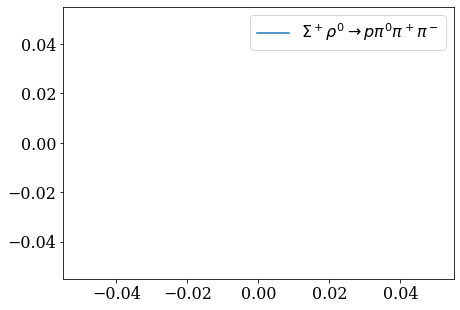

In [102]:
DecaySelector = rand.uniform(0,sum(BranchingRatios))
cumulant = 0
for BRindex in range(len(BranchingRatios)):
    cumulant += BranchingRatios[BRindex]
    if DecaySelector < cumulant:
        ChannelIndex = BRindex
        break
plt.plot([],[],label=DecayChannels[ChannelIndex])
plt.legend()
plt.show()

In [107]:
d1 = {a:[] for a in "decay_channel decay_index initial_names intmdt_names final_names".split()} # 
d1.update({a+"_"+b:[] for a in "initial intmdt final".split() for b in "E px py pz p theta phi".split()}) # 
#can we search through a list/1D array in the IntParticleNames slot to find all decays with intermediate lambda?
#Do we need to append Ntype if we can search the final_names for 2112/GeantID/"n"

nEvents = 10000

for i in range(nEvents):
    #select which decay channel to use
    DecaySelector = rand.uniform(0,sum(BranchingRatios))
    cumulant = 0
    for BRindex in range(len(BranchingRatios)):
        cumulant += BranchingRatios[BRindex]
        if DecaySelector < cumulant:
            DecayIndex = BRindex
            break
    d1["decay_index"].append(DecayIndex)
    d1["decay_channel"].append(DecayChannels[DecayIndex])
    #initialize lists for initial, intermediate, and final particle properties
    inits = {}
    intmdts = {}
    finals = {}
    names,Es,pxs,pys,pzs,ps,thetas,phis,=[],[],[],[],[],[],[],[]
    inames,iEs,ipxs,ipys,ipzs,ips,ithetas,iphis,=[],[],[],[],[],[],[],[]
    fnames,fEs,fpxs,fpys,fpzs,fps,fthetas,fphis,=[],[],[],[],[],[],[],[]
    
    inits["D_0"],inits["e"],inits["\\Lambda^+_c"] = ep_to_d0_e_lambdac.next(P0)

    if DecayIndex == 0:
        #\\mu^+ \\Lambda \\rightarrow \\mu^+ n \\pi^0
        intmdts["\\Lambda"],finals["\\nu_{mu}"],finals["\\mu^+"] = lambdac_to_lambdamu.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 1:
        #\\mu^+ \\Lambda \\rightarrow \\mu^+ n \\pi^+
        intmdts["\\Lambda"],finals["\\nu_{mu}"],finals["\\mu^+"] = lambdac_to_lambdamu.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 2:
        #n \\pi^+ K^0_S \\rightarrow n \\pi^+ \\pi^+ \\pi^-
        finals["n"],finals["\\pi^+"],intmdts["\\K^0_S"] = lambdac_to_nKspi.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (K^0_S)"], finals["\\pi^- (K^0_S)"] = Kshort_to_picharged.next(intmdts["\\K^0_S"])
        
    elif DecayIndex == 3:
        #n \\pi^+ K^0_S \\rightarrow n \\pi^+ \\pi^0 \\pi^0
        finals["n"],finals["\\pi^+"],intmdts["\\K^0_S"] = lambdac_to_nKspi.next(inits["\\Lambda^+_c"])
        finals["\\pi^0 (K^0_S)"], finals["\\pi^0 (K^0_S)"] = Kshort_to_pi0.next(intmdts["\\K^0_S"])
        
    elif DecayIndex == 4:
        #p K^0_S \\rightarrow p \\pi^+ \\pi^+
        finals["p"],intmdts["\\K^0_S"] = lambdac_to_pKs.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (K^0_S)"], finals["\\pi^- (K^0_S)"] = Kshort_to_picharged.next(intmdts["\\K^0_S"])
    
    elif DecayIndex == 5:
        #p K^0_S \\rightarrow p \\pi^0 \\pi^0
        finals["p"],intmdts["\\K^0_S"] = lambdac_to_pKs.next(inits["\\Lambda^+_c"])
        finals["\\pi^0 (K^0_S)"], finals["\\pi^0 (K^0_S)"] = Kshort_to_pi0.next(intmdts["\\K^0_S"])
        
    elif DecayIndex == 6:
        #p K^- \\pi^+ (NR)
        finals["p"],finals["\\K^-"],finals["\\pi^+"] = lambdac_to_pKpi.next(inits["\\Lambda^+_c"])
        
    elif DecayIndex == 7:
        #p \\overline{K}^{*}\\left(892\\right)^0
        finals["p"],intmdts["\\overline{K}^{*}\\left(892\\right)^0"] = lambdac_to_pKstar.next(inits["\\Lambda^+_c"])
        finals["\\K^+ (\\overline{K}^{*}\\left(892\\right)^0)"], finals["\\pi^- (\\overline{K}^{*}\\left(892\\right)^0)"] = Kstar_to_kpi.next(intmdts["\\overline{K}^{*}\\left(892\\right)^0"])
    
    elif DecayIndex == 8:
        #p K^0_S \\pi^0 \\rightarrow p \\pi^+ \\pi^- \\pi^0
        finals["p"],intmdts["\\K^0_S"],finals["\\pi^0"] = lambdac_to_pK0pi0.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (K^0_S)"], finals["\\pi^- (K^0_S)"] = Kshort_to_picharged.next(intmdts["\\K^0_S"])
        
    elif DecayIndex == 9:
        #p K^0_S \\pi^0 \\rightarrow p \\pi^+ \\pi^- \\pi^0
        finals["p"],intmdts["\\K^0_S"],finals["\\pi^0"] = lambdac_to_pK0pi0.next(inits["\\Lambda^+_c"])
        finals["\\pi^0 (K^0_S)"], finals["\\pi^0 (K^0_S)"] = Kshort_to_pi0.next(intmdts["\\K^0_S"])
        
    elif DecayIndex == 10:
        #p \\overline{K}^0 \\eta \\rightarrow p K^0_L \\eta
        finals["p"],intmdts["\\overline{K}^0"],finals["\\eta"] = lambdac_to_pK0eta.next(inits["\\Lambda^+_c"])
        finals["K^0_L (\\overline{K}^0)"] = intmdts["\\overline{K}^0"]
        
    elif DecayIndex == 11:
        #p \\overline{K}^0 \\eta \\rightarrow p \\pi^+ \\pi^- \\eta
        finals["p"],intmdts["\\overline{K}^0"],finals["\\eta"] = lambdac_to_pK0eta.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\overline{K}^0)"], finals["\\pi^- (\\overline{K}^0)"] = Kshort_to_picharged.next(intmdts["\\overline{K}^0"])
        
    elif DecayIndex == 12:
        #p \\overline{K}^0 \\eta \\rightarrow p \\pi^0 \\pi^0 \\eta
        finals["p"],intmdts["\\overline{K}^0"],finals["\\eta"] = lambdac_to_pK0eta.next(inits["\\Lambda^+_c"])
        finals["\\pi^0 (\\overline{K}^0)"], finals["\\pi^0 (\\overline{K}^0)"] = Kshort_to_pi0.next(intmdts["\\overline{K}^0"])
        
    elif DecayIndex == 13:
        #p K^* \\left(892\\right)^- \\pi^+ \\rightarrow p K^- \\pi^0 \\pi^+
        finals["p"],intmdts["K^*\\left(892\\right)^-"],finals["\\pi^+"] = lambdac_to_pKstarpi.next(inits["\\Lambda^+_c"])
        finals["\\K^0 (K^*\\left(892\\right)^-)"], finals["\\pi^- (K^*\\left(892\\right)^-)"] = KstarN_to_kpi0.next(intmdts["K^*\\left(892\\right)^-"])
        
    elif DecayIndex == 14:
        #\\Lambda \\pi^+ \\rightarrow p \\pi^- \\pi^+
        intmdts["\\Lambda"],finals["\\pi^+"] = lambdac_to_lambdapi.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 15:
        #\\Lambda \\pi^+ \\rightarrow n \\pi^0 \\pi^+
        intmdts["\\Lambda"],finals["\\pi^+"] = lambdac_to_lambdapi.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 16:
        #\\Lambda \\pi^+ \\pi^0 \\rightarrow p \\pi^- \\pi^+ \\pi^0
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\pi^0"] = lambdac_to_lambdapipi0.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 17:
        #\\Lambda \\pi^+ \\pi^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^0
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\pi^0"] = lambdac_to_lambdapipi0.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 18:
        #\\Lambda \\rho^+ \\rightarrow p \\pi^- \\pi^+ \\pi^0
        intmdts["\\Lambda"],intmdts["\\rho^+"] = lambdac_to_lambdarho.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^+)"], finals["\\pi^0 (\\rho^+)"] = rho_to_pipi0.next(intmdts["\\rho^+"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 19:
        #\\Lambda \\rho^+ \\rightarrow \\mu^+ n \\pi^0 \\pi^+ \\pi^0
        intmdts["\\Lambda"],intmdts["\\rho^+"] = lambdac_to_lambdarho.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^+)"], finals["\\pi^0 (\\rho^+)"] = rho_to_pipi0.next(intmdts["\\rho^+"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 20:
        #\\Lambda \\pi^+ \\rho^0 \\rightarrow p \\pi^- \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Lambda"],intmdts["\\rho^0"],finals["\\pi^+"] = lambdac_to_lambdarhopi.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^0)"], finals["\\pi^- (\\rho^0)"] = rho_to_pipi.next(intmdts["\\rho^0"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 21:
        #\\Lambda \\pi^+ \\rho^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Lambda"],intmdts["\\rho^0"],finals["\\pi^+"] = lambdac_to_lambdarhopi.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^0)"], finals["\\pi^- (\\rho^0)"] = rho_to_pipi.next(intmdts["\\rho^0"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 22:
        #\\Lambda \\pi^+ \\eta \\rightarrow p \\pi^- \\pi^+ \\eta
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\eta"] = lambdac_to_lambdapieta.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 23:
        #\\Lambda \\pi^+ \\eta \\rightarrow n \\pi^0 \\pi^+ \\eta
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\eta"] = lambdac_to_lambdapieta.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 24:
        #\\Lambda \\pi^+ \\omega \\rightarrow p \\pi^- \\pi^+ \\omega
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\omega"] = lambdac_to_lambdapiomega.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])

    elif DecayIndex == 25:
        #\\Lambda \\pi^+ \\omega \\rightarrow n \\pi^0 \\pi^+ \\omega
        intmdts["\\Lambda"],finals["\\pi^+"],finals["\\omega"] = lambdac_to_lambdapiomega.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        
    elif DecayIndex == 26:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- K^0_L K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])
        finals["K^0_L (\\overline{K}^0)"] = intmdts["\\overline{K}^0"]

    elif DecayIndex == 27:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 K^0_L K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        finals["K^0_L (\\overline{K}^0)"] = intmdts["\\overline{K}^0"]
        
    elif DecayIndex == 28:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- \\pi^+ \\pi^- K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])
        finals["\\pi^+ (\\overline{K}^0)"], finals["\\pi^- (\\overline{K}^0)"] = Kshort_to_picharged.next(intmdts["\\overline{K}^0"])

    elif DecayIndex == 29:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^- K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        finals["\\pi^+ (\\overline{K}^0)"], finals["\\pi^- (\\overline{K}^0)"] = Kshort_to_picharged.next(intmdts["\\overline{K}^0"])
        
    elif DecayIndex == 30:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow p \\pi^- \\pi^+ \\pi^- K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda"])
        finals["\\pi^0 (\\overline{K}^0)"], finals["\\pi^0 (\\overline{K}^0)"] = Kshort_to_pi0.next(intmdts["\\overline{K}^0"])

    elif DecayIndex == 31:
        #\\Lambda K^+ \\overline{K}^0 \\rightarrow n \\pi^0 \\pi^+ \\pi^- K^+
        intmdts["\\Lambda"],intmdts["\\overline{K}^0"],finals["K^+"] = lambdac_to_lambdaKK0.next(inits["\\Lambda^+_c"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda"])
        finals["\\pi^0 (\\overline{K}^0)"], finals["\\pi^0 (\\overline{K}^0)"] = Kshort_to_pi0.next(intmdts["\\overline{K}^0"])
    
    elif DecayIndex == 32:
        #\\Sigma^+ \\pi^0 \\rightarrow p \\pi^0 \\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"] = lambdac_to_SigmaPpi0.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 33:
        #\\Sigma^+ \\pi^0 \\rightarrow n \\pi^+ \\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"] = lambdac_to_SigmaPpi0.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 34:
        #\\Sigma^+ \\pi^0 \\rightarrow n \\pi^+ \\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"] = lambdac_to_SigmaPpi0.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 35:
        #\\Sigma^+ \\eta \\rightarrow p \\pi^0 \\eta
        intmdts["\\Sigma^+"],finals["\\eta"] = lambdac_to_SigmaPeta.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 36:
        #\\Sigma^+  \\eta \\rightarrow n \\pi^+ \\eta
        intmdts["\\Sigma^+"],finals["\\eta"] = lambdac_to_SigmaPeta.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 37:
        #\\Sigma^+ \\eta \\rightarrow n \\pi^+ \\eta
        intmdts["\\Sigma^+"],finals["\\eta"] = lambdac_to_SigmaPeta.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 38:
        #\\Sigma^+ \\eta^{\'} \\rightarrow p \\pi^0 \\eta^{\'}
        intmdts["\\Sigma^+"],finals["\\eta^{\'}"] = lambdac_to_SigmaPetaprime.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 39:
        #\\Sigma^+ \\eta^{\'} \\rightarrow n \\pi^+ \\eta^{\'}
        intmdts["\\Sigma^+"],finals["\\eta^{\'}"] = lambdac_to_SigmaPetaprime.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 40:
        #\\Sigma^+ \\eta^{\'} \\rightarrow n \\pi^+ \\eta^{\'}
        intmdts["\\Sigma^+"],finals["\\eta^{\'}"] = lambdac_to_SigmaPetaprime.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 41:
        #\\Sigma^+ \\pi^+ \\pi^- \\rightarrow p \\pi^0 \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],finals["\\pi^+"],finals["\\pi^-"] = lambdac_to_SigmaPpipi.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 42:
        #\\Sigma^+ \\pi^+ \\pi^- \\rightarrow n \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],finals["\\pi^+"],finals["\\pi^-"] = lambdac_to_SigmaPpipi.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 43:
        #\\Sigma^+ \\pi^+ \\pi^- \\rightarrow n \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],finals["\\pi^+"],finals["\\pi^-"] = lambdac_to_SigmaPpipi.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 44:
        #\\Sigma^+ \\rho^0 \\rightarrow p \\pi^0 \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],intmdts["\\rho^0"] = lambdac_to_SigmaPrho.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^0)"], finals["\\pi^- (\\rho^0)"] = rho_to_pipi.next(intmdts["\\rho^0"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 45:
        #\\Sigma^+ \\rho^0 \\rightarrow n \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],intmdts["\\rho^0"] = lambdac_to_SigmaPrho.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^0)"], finals["\\pi^- (\\rho^0)"] = rho_to_pipi.next(intmdts["\\rho^0"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 46:
        #\\Sigma^+ \\rho^0 \\rightarrow n \\pi^+ \\pi^+ \\pi^-
        intmdts["\\Sigma^+"],intmdts["\\rho^0"] = lambdac_to_SigmaPrho.next(inits["\\Lambda^+_c"])
        finals["\\pi^+ (\\rho^0)"], finals["\\pi^- (\\rho^0)"] = rho_to_pipi.next(intmdts["\\rho^0"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 47:
        #\\Sigma^+ 2\\pi^0 \\rightarrow p \\pi^0 2\\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"],finals["\\pi^0"] = lambdac_to_SigmaPpi0pi0.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 48:
        #\\Sigma^+ 2\\pi^0 \\rightarrow n \\pi^+ 2\\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"],finals["\\pi^0"] = lambdac_to_SigmaPpi0pi0.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 49:
        #\\Sigma^+ 2\\pi^0 \\rightarrow n \\pi^+ 2\\pi^0
        intmdts["\\Sigma^+"],finals["\\pi^0"],finals["\\pi^0"] = lambdac_to_SigmaPpi0pi0.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])

    elif DecayIndex == 50:
        #\\Sigma^+ \\omega \\rightarrow p \\pi^0 \\omega
        intmdts["\\Sigma^+"],finals["\\omega"] = lambdac_to_SigmaPomega.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 51:
        #\\Sigma^+ \\omega \\rightarrow n \\pi^+ \\omega
        intmdts["\\Sigma^+"],finals["\\omega"] = lambdac_to_SigmaPomega.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 52:
        #\\Sigma^+ \\omega \\rightarrow n \\pi^+ \\omega
        intmdts["\\Sigma^+"],finals["\\omega"] = lambdac_to_SigmaPomega.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 53:
        #\\Sigma^+ \\phi \\rightarrow p \\pi^0 \\phi
        intmdts["\\Sigma^+"],finals["\\phi"] = lambdac_to_SigmaPphi.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\pi^0 (\\Sigma^+)"] = SigmaP_to_ppi0.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 54:
        #\\Sigma^+ \\phi \\rightarrow n \\pi^+ \\phi
        intmdts["\\Sigma^+"],finals["\\phi"] = lambdac_to_SigmaPphi.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^+)"], finals["\\pi^+ (\\Sigma^+)"] = SigmaP_to_npi.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 55:
        #\\Sigma^+ \\phi \\rightarrow n \\pi^+ \\phi
        intmdts["\\Sigma^+"],finals["\\phi"] = lambdac_to_SigmaPphi.next(inits["\\Lambda^+_c"])
        finals["p (\\Sigma^+)"], finals["\\gamma (\\Sigma^+)"] = SigmaP_to_pgamma.next(intmdts["\\Sigma^+"])
        
    elif DecayIndex == 56:
        #\\Sigma^0 \\pi^+ \\rightarrow \\Lambda \\pi^+ \\rightarrow p \\pi^- \\pi^+
        intmdts["\\Sigma^0"],finals["\\pi^+"] = lambdac_to_Sigma0pi.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 57:
        #\\Sigma^0 \\pi^+ \\rightarrow \\Lambda \\pi^+ \\rightarrow n \\pi^0 \\pi^+
        intmdts["\\Sigma^0"],finals["\\pi^+"] = lambdac_to_Sigma0pi.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 58:
        #\\Sigma^0 \\pi^+ \\eta \\rightarrow \\Lambda \\gamma \\pi^+ \\eta \\rightarrow p \\pi^- \\gamma \\pi^+ \\eta
        intmdts["\\Sigma^0"],finals["\\pi^+"],finals["\\eta"] = lambdac_to_Sigma0pieta.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 59:
        #\\Sigma^0 \\pi^+ \\eta \\rightarrow \\Lambda \\gamma \\pi^+ \\eta \\rightarrow n \\pi^0 \\gamma \\pi^+ \\eta
        intmdts["\\Sigma^0"],finals["\\pi^+"],finals["\\eta"] = lambdac_to_Sigma0pieta.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 60:
        #\\Sigma^0 \\pi^+ \\pi^0 \\rightarrow \\Lambda \\gamma \\pi^+ \\pi^0 \\rightarrow p \\pi^- \\gamma \\pi^+ \\pi^0
        intmdts["\\Sigma^0"],finals["\\pi^+"],finals["\\pi^0"] = lambdac_to_Sigma0pipi0.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["p (\\Lambda)"], finals["\\pi^- (\\Lambda)"] = lambda_to_ppi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 61:
        #\\Sigma^0 \\pi^+ \\pi^0 \\rightarrow \\Lambda \\gamma \\pi^+ \\pi^0 \\rightarrow n \\pi^0 \\gamma \\pi^+ \\pi^0
        intmdts["\\Sigma^0"],finals["\\pi^+"],finals["\\pi^0"] = lambdac_to_Sigma0pipi0.next(inits["\\Lambda^+_c"])
        intmdts["\\Lambda (\\Sigma^0)"], finals["\\gamma (\\Sigma^0)"] = Sigma0_to_Lambdagamma.next(intmdts["\\Sigma^0"])
        finals["n (\\Lambda)"], finals["\\pi^0 (\\Lambda)"] = lambda_to_npi.next(intmdts["\\Lambda (\\Sigma^0)"])
        
    elif DecayIndex == 62:
        #\\Sigma^- 2\\pi^+ \\rightarrow n \\pi^- 2\\pi^+
        intmdts["\\Sigma^-"],finals["\\pi^+"],finals["\\pi^+"] = lambdac_to_SigmaN2pi.next(inits["\\Lambda^+_c"])
        finals["n (\\Sigma^-)"], finals["\\pi^- (\\Sigma^-)"] = SigmaN_to_npi.next(intmdts["\\Sigma^-"])


    #append initial, intermediate, and final particle properties into a single list
    for key in inits.keys():
        names.append(key)
        Es.append(inits[key].E())
        pxs.append(inits[key].Px())
        pys.append(inits[key].Py())
        pzs.append(inits[key].Pz())
        ps.append(inits[key].P())
        thetas.append(inits[key].Theta())
        phis.append(inits[key].Phi())
    
    for key in intmdts.keys():
        inames.append(key)
        iEs.append(intmdts[key].E())
        ipxs.append(intmdts[key].Px())
        ipys.append(intmdts[key].Py())
        ipzs.append(intmdts[key].Pz())
        ips.append(intmdts[key].P())
        ithetas.append(intmdts[key].Theta())
        iphis.append(intmdts[key].Phi())

    for key in finals.keys():
        fnames.append(key)
        fEs.append(finals[key].E())
        fpxs.append(finals[key].Px())
        fpys.append(finals[key].Py())
        fpzs.append(finals[key].Pz())
        fps.append(finals[key].P())
        fthetas.append(finals[key].Theta())
        fphis.append(finals[key].Phi())
    
    #append values and lists into output dataframe
    d1["initial_names"].append(names)
    d1["initial_E"].append(Es)
    d1["initial_px"].append(pxs)
    d1["initial_py"].append(pys)
    d1["initial_pz"].append(pzs)
    d1["initial_p"].append(ps)
    d1["initial_theta"].append(thetas)
    d1["initial_phi"].append(phis)
    
    d1["intmdt_names"].append(inames)
    d1["intmdt_E"].append(iEs)
    d1["intmdt_px"].append(ipxs)
    d1["intmdt_py"].append(ipys)
    d1["intmdt_pz"].append(ipzs)
    d1["intmdt_p"].append(ips)
    d1["intmdt_theta"].append(ithetas)
    d1["intmdt_phi"].append(iphis)
    
    d1["final_names"].append(fnames)
    d1["final_E"].append(fEs)
    d1["final_px"].append(fpxs)
    d1["final_py"].append(fpys)
    d1["final_pz"].append(fpzs)
    d1["final_p"].append(fps)
    d1["final_theta"].append(fthetas)
    d1["final_phi"].append(fphis)

df = pd.DataFrame(d1)

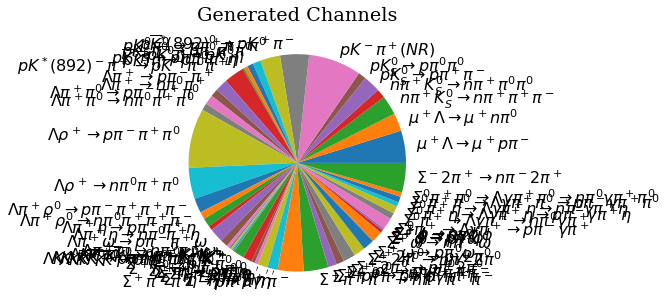

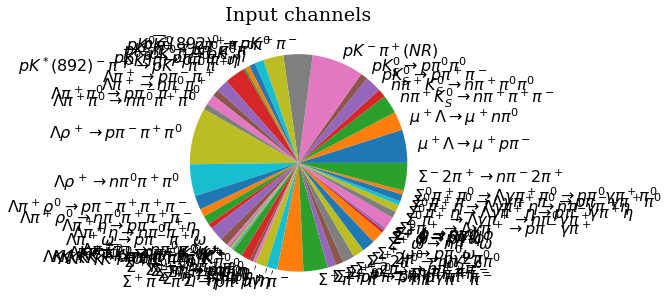

Generated events with \Lambda: 3618
Generated events with \Sigma*: 3488
Generated events with p: 6435
Generated events with n: 3565
Generated events with \mu^+: 747


In [109]:
evtperchannel=[]
for i in range(len(DecayChannels)):
    evtperchannel.append(len(df.query(f"decay_index=={i}")))
               
plt.pie(evtperchannel,labels=DecayChannels)
plt.title("Generated Channels")
plt.show()

evtperchannel=[]
for i in range(len(DecayChannels)):
    evtperchannel.append(len(df.query(f"decay_index=={i}")))
               
plt.pie(BranchingRatios,labels=DecayChannels)
plt.title("Input channels")
plt.show()

has_lambda=[]
for namelist in df.intmdt_names:
    mask = '\\Lambda' in namelist
    has_lambda.append(mask)
print(f"Generated events with \\Lambda: {len(df.intmdt_names[has_lambda])}")

has_Sigma=[]
for namelist in df.intmdt_names:
    mask = '\\Sigma^+' in namelist or '\\Sigma^0' in namelist or '\\Sigma^-' in namelist
    has_Sigma.append(mask)
print(f"Generated events with \\Sigma*: {len(df.intmdt_names[has_Sigma])}")

has_p=[]
for namelist in df.final_names:
    mask = 'p' in namelist or 'p (\\Lambda)' in namelist or 'p (\\Sigma^+)' in namelist
    has_p.append(mask)
print(f"Generated events with p: {len(df[has_p])}")

has_n=[]
for namelist in df.final_names:
    mask = 'n' in namelist or 'n (\\Lambda)' in namelist or 'n (\\Sigma^+)' in namelist or 'n (\\Sigma^-)' in namelist
    has_n.append(mask)
print(f"Generated events with n: {len(df[has_n])}")

has_mu=[]
for namelist in df.final_names:
    mask = '\\mu^+' in namelist
    has_mu.append(mask)
print(f"Generated events with \\mu^+: {len(df[has_mu])}")

In [106]:
df

,decay_channel,decay_index,initial_names,intmdt_names,final_names,initial_E,initial_px,initial_py,initial_pz,initial_p,...,intmdt_p,intmdt_theta,intmdt_phi,final_E,final_px,final_py,final_pz,final_p,final_theta,final_phi
0,$\Lambda \rho^+ \rightarrow n \pi^0 \pi^+ \pi^0$,19,"[D_0, e, \Lambda^+_c]","[\Lambda, \rho^+]","[\pi^+ (\rho^+), \pi^0 (\rho^+), n (\Lambda), ...","[3.9065644376600304, 1.0007293329162443, 6.031...","[-0.11019003591453547, 0.0, 0.11019003591453547]","[0.22592211376271873, 0.0, -0.22592211376271873]","[3.423512061390783, 1.0007292024508885, 5.5757...","[3.432727411256249, 1.0007292024508885, 5.5814...",...,"[1.597360642392763, 4.0083097481153755]","[0.1532229622159509, 0.07476451300920647]","[0.18135289316750924, -2.018493576804301]","[2.6364760848414353, 1.4461180787311214, 1.510...","[0.23033866972244826, -0.3599462923415202, 0.2...","[-0.03970684123083529, -0.23018638538157543, 0...","[2.6226224680519272, 1.3744898079824193, 1.164...","[2.6330174982215406, 1.4393642129888427, 1.183...","[0.08888817445906254, 0.30137774888595703, 0.1...","[-0.1707068685211661, -2.5726328113402324, 0.0..."
1,$\Sigma^+ \pi^0 \rightarrow n \pi^+ \pi^0$,33,"[D_0, e, \Lambda^+_c]",[\Sigma^+],"[\pi^0, n (\Sigma^+), \pi^+ (\Sigma^+)]","[4.578789134591858, 0.305807028263958, 6.05370...","[-0.09078281896831551, 0.0, 0.09078281896831551]","[-0.6615697805319699, 0.0, 0.6615697805319699]","[4.128167343837154, 0.3058066013261212, 5.5660...","[4.181827556637941, 0.3058066013261212, 5.6059...",...,[2.6592381763585746],[0.20509019353567945],[-2.805053077259881],"[3.1406043408168114, 2.034253623983273, 0.8788...","[0.601970855827525, -0.397021594125255, -0.114...","[0.8404079934802008, -0.23027712266338135, 0.0...","[2.9625185431970307, 1.7449028475147816, 0.858...","[3.137701487643048, 1.8042559814752113, 0.8676...","[0.33573507641093514, 0.25720863655075177, 0.1...","[0.9492248572733615, -2.616000193954685, 2.718..."
2,$p K^* \left(892\right)^- \pi^+ \rightarrow p ...,13,"[D_0, e, \Lambda^+_c]",[K^*\left(892\right)^-],"[p, \pi^+, \K^0 (K^*\left(892\right)^-), \pi^-...","[5.253588731046671, 0.03384558127217772, 5.650...","[-0.36381528673147223, 0.0, 0.36381528673147223]","[-0.6608560945838899, 0.0, 0.6608560945838899]","[4.853192144225529, 0.033841723517746364, 5.11...","[4.9114729287028105, 0.033841723517746364, 5.1...",...,[3.0596092360456475],[0.18461546682583194],[1.8557453740586767],"[1.861201252433721, 0.6016841216640955, 2.8190...","[0.272493448488307, 0.24920590241904475, -0.30...","[0.15299067647747527, -0.031134700015407687, 0...","[1.5767068165967844, 0.5286422901330864, 2.699...","[1.607377744048004, 0.5852654288976021, 2.7754...","[0.19566470040953182, 0.44350729393860583, 0.2...","[0.5115893273511084, -0.12429162856428981, 2.0..."
3,$\Lambda K^+ \overline{K}^0 \rightarrow p \pi^...,26,"[D_0, e, \Lambda^+_c]","[\Lambda, \overline{K}^0]","[K^+, p (\Lambda), \pi^- (\Lambda), K^0_L (\ov...","[5.933805750411116, 0.0665975005721344, 4.9378...","[0.5353435524455661, 0.0, -0.5353435524455661]","[0.30358821635735295, 0.0, -0.30358821635735295]","[5.59943425122181, 0.06659554010183746, 4.3339...","[5.633153864223134, 0.06659554010183746, 4.377...",...,"[2.4916120101848285, 1.3349311769511467]","[0.17794626953794376, 0.24479392326206786]","[-2.461159448811974, 2.8961469097754033]","[0.7832399560516433, 2.099069702693564, 0.6309...","[0.1213071733241154, -0.2435461604860649, -0.0...","[-0.10473270008873777, -0.24127274536326915, -...","[0.5865692454084308, 1.8461201089916695, 0.606...","[0.6080689503886713, 1.8776812101009177, 0.615...","[0.26671217181737467, 0.18360746986849727, 0.1...","[-0.712203715162572, -2.360883660586659, -2.79..."
4,$\mu^+ \Lambda \rightarrow \mu^+ p \pi^-$,0,"[D_0, e, \Lambda^+_c]",[\Lambda],"[\nu_{mu}, \mu^+, p (\Lambda), \pi^- (\Lambda)]","[5.70310886600945, 0.23278873435305558, 5.0024...","[0.5859976774358064, 0.0, -0.5859976774358064]","[-0.09263734491270947, 0.0, 0.09263734491270947]","[5.356850525852198, 

In [58]:
d1 = {a:[] for a in "decay_channel initial_names intmdt_names final_names".split()}
d1.update({a+"_"+b:[] for a in "initial intmdt final".split() for b in "E px py pz p theta phi".split()})
for key in d1.keys():
    print(type(key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [15]:
#lambdac -> lambda + mu + neutrino decay
d1 = {a+"_"+b:[] for a in "D0 e lambdac lambda numu mu N pi".split() for b in "E px py pz p theta phi".split()}
#nucleon type that the lambda decays into (2212 or 2112 for p or n)
d1["Ntype"] =[]
for i in range(100000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    
    
    d["lambda"],d["numu"],d["mu"] = lambdac_to_lambdamu.next(d["lambdac"])
    
    if(rand.uniform(0,1)<.64):
        Ntype = 2212
        d["N"], d["pi"] = lambda_to_ppi.next(d['lambda'])
    else :
        Ntype= 2112
        d["N"], d["pi"] = lambda_to_npi.next(d['lambda'])
    d1["Ntype"].append(Ntype)
    
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df = pd.DataFrame(d1)

In [16]:
def check_decay(df, mother, daughters):
    masses={}
    masses["D0"]=mD0
    masses["lambdac"]=mLambdaC
    masses["lambda"]=mLambda
    masses["mu"]=mMu
    masses["numu"]=0
    #first check conservation of momentum
    for comp in "E px py pz".split():
        #build a string to be evaluated by the df
        str1=mother+"_"+comp
        for d in daughters:
            str1+=" - "+d+"_"+comp
        print(comp,np.mean(df.eval(f"({str1})**2")))
    #next check that the four momenta of the mother and daughter particles have the correct masses.
    for part in [mother]+daughters:
        str2=f"({part}_E**2-{part}_px**2-{part}_py**2-{part}_pz**2)-{masses[part]}**2"
        print(part, np.mean(df.eval(str2)**2))
check_decay(df, "lambdac", ["lambda", "mu", "numu"])

E 2.3107275877700523e-29
px 8.426562244370477e-32
py 8.433436582617245e-32
pz 2.0181576915589517e-29
lambdac 6.861278650784415e-29
lambda 1.1802582369547494e-29
mu 1.0247093269470972e-30
numu 8.5543665248025e-31


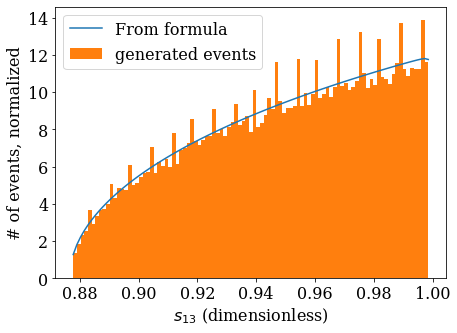

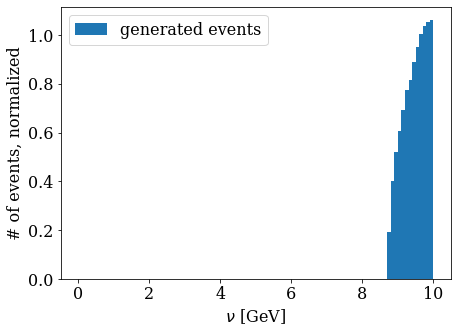

In [17]:
#check the distribution of the s13 variable, and the photon energy for the photoproduction

#show the pdf for the s13 variable
Ebeam=10
mD0=1.86484
mLambdaC=2.2849
mp = 0.9383
stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

s13_min = (np.sqrt(x1)+np.sqrt(x3))**2
s13_max =(1-np.sqrt(x2))**2
s13 =np.linspace(s13_min,s13_max, 100)[1:-1]
binwidth=s13[1]-s13[0]
pdf = np.sqrt(((1+x2-s13)**2-4*x2)*((x1+x3-s13)**2-4*x1*x3))/s13
#apply photoproduction correction
pdf /=(1-s13)/2
pdf /=sum(pdf)*binwidth
plt.plot(s13, pdf, label="From formula")

plt.hist(df.eval(f"((D0_E+lambdac_E)**2-(D0_px+lambdac_px)**2-(D0_py+lambdac_py)**2-(D0_pz+lambdac_pz)**2)/{P0.M()**2}"), bins=s13,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{13}$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

plt.hist(df.eval(f"{Ebeam}-e_E"), bins=np.linspace(0, Ebeam,101),density = True, label="generated events")
plt.legend()
plt.xlabel("$\\nu$ [GeV]")
plt.ylabel("# of events, normalized")
plt.show()

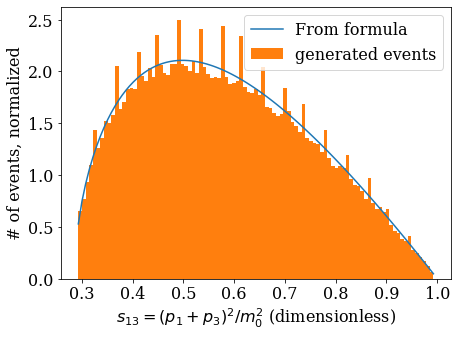

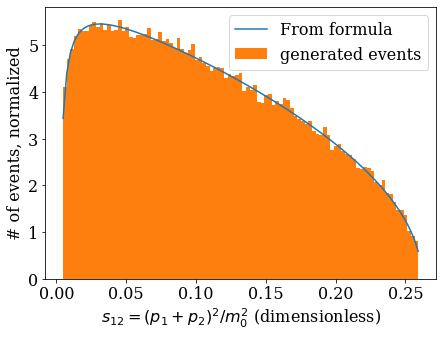

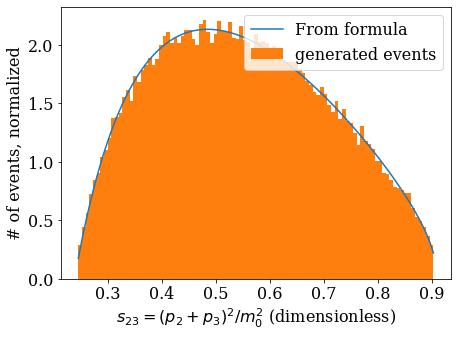

In [18]:
#check the distributions of the s13, s23, and s12 variables in the lambdac decay


stot = mLambdaC**2
x1 = mMu**2/stot
x2 = 1e-7/stot
x3 = mLambda**2/stot

part1="mu"
part2="numu"
part3="lambda"

s13_min = (np.sqrt(x1)+np.sqrt(x3))**2
s13_max =(1-np.sqrt(x2))**2
s13 =np.linspace(s13_min,s13_max, 100)[1:-1]
binwidth=s13[1]-s13[0]
pdf = np.sqrt(((1+x2-s13)**2-4*x2)*((x1+x3-s13)**2-4*x1*x3))/s13

pdf /=sum(pdf)*binwidth
plt.plot(s13, pdf, label="From formula")

plt.hist(df.eval(f"(({part1}_E+{part3}_E)**2-({part1}_px+{part3}_px)**2-({part1}_py+{part3}_py)**2-({part1}_pz+{part3}_pz)**2)/{stot}"), bins=s13,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{13}=(p_1+p_3)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

s12_min = (np.sqrt(x1)+np.sqrt(x2))**2
s12_max =(1-np.sqrt(x3))**2
s12 =np.linspace(s12_min,s12_max, 100)[1:-1]
binwidth=s12[1]-s12[0]
pdf = np.sqrt(((1+x3-s12)**2-4*x3)*((x1+x2-s12)**2-4*x1*x2))/s12

pdf /=sum(pdf)*binwidth
plt.plot(s12, pdf, label="From formula")
part1="mu"
part3="lambda"
plt.hist(df.eval(f"(({part1}_E+{part2}_E)**2-({part1}_px+{part2}_px)**2-({part1}_py+{part2}_py)**2-({part1}_pz+{part2}_pz)**2)/{stot}"), bins=s12,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{12}=(p_1+p_2)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

s23_min = (np.sqrt(x3)+np.sqrt(x2))**2
s23_max =(1-np.sqrt(x1))**2
s23 =np.linspace(s23_min,s23_max, 100)[1:-1]
binwidth=s23[1]-s23[0]
pdf = np.sqrt(((1+x1-s23)**2-4*x1)*((x2+x3-s23)**2-4*x2*x3))/s23

pdf /=sum(pdf)*binwidth
plt.plot(s23, pdf, label="From formula")
part1="mu"
part3="lambda"
plt.hist(df.eval(f"(({part2}_E+{part3}_E)**2-({part2}_px+{part3}_px)**2-({part2}_py+{part3}_py)**2-({part2}_pz+{part3}_pz)**2)/{stot}"), bins=s23,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{23}=(p_2+p_3)^2/m^2_0$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

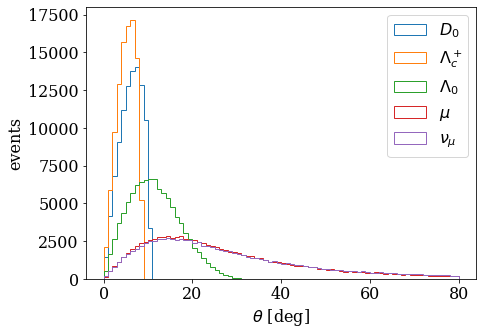

In [19]:
plt.hist(df.D0_theta*180/np.pi,bins=np.linspace(0,80,81), label="$D_0$", histtype='step')
plt.hist(df.lambdac_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\Lambda^+_c$", histtype='step')
plt.hist(df.lambda_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\Lambda_0$", histtype='step')
plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\mu$", histtype='step')
plt.hist(df.numu_theta*180/np.pi,bins=np.linspace(0,80,81), label="$\\nu_\\mu$", histtype='step')
plt.legend()
plt.xlabel("$\\theta$ [deg]")
plt.ylabel("events")
plt.show()

In [20]:
#what fraction of the events have a muon that enters the acceptance of the fcal?
#plot the theta distribution of the accepted events and all events.
z_front = 1300
detector_length=300
detector_ymin = -220
detector_ymax = -8
uxmax = (detector_length/2)/z_front
uymin = detector_ymin/z_front
uymax = detector_ymax/z_front

def acceptance_condition(particle_name):
    return f"abs({particle_name}_px/{particle_name}_pz)<{uxmax} and {particle_name}_py/{particle_name}_pz>{uymin} and {particle_name}_py/{particle_name}_pz<{uymax}"

0.05682 +- 0.0007320620711387799


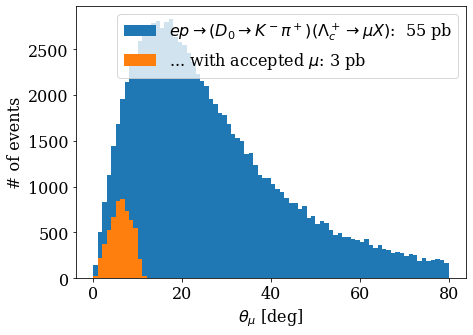

In [26]:
#muon acceptance
tot_nb = 40

f_D0_Kminus_piplus=.03946


accepted = df.query(acceptance_condition("mu"))
num = len(accepted)
denom = len(df)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))



#label =f"all events with muon:  {tot_nb*f_lamdba_c_mu:.2f} nb"
label = f"$ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow \\mu X)$:  {tot_nb*f_lambdac_to_lambdamu*f_D0_Kminus_piplus*1000:.0f} pb"
plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label=label)

#label = f"events with accepted muon\n{tot_nb*f_lambda_c_mu*num/denom:.2f} nb\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)"
#label = f"events with accepted muon:\n{tot_nb*f_lambda_c_mu*num/denom:.2f} nb"
label = f"... with accepted $\\mu$: {tot_nb*f_lambdac_to_lambdamu*f_D0_Kminus_piplus*num/denom*1000:.0f} pb"
plt.hist(accepted.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=label)
plt.legend()
plt.xlabel("$\\theta_\mu$ [deg]")
plt.ylabel("# of events")
plt.show()

0.16816331083719113 +- 0.001975111551324876


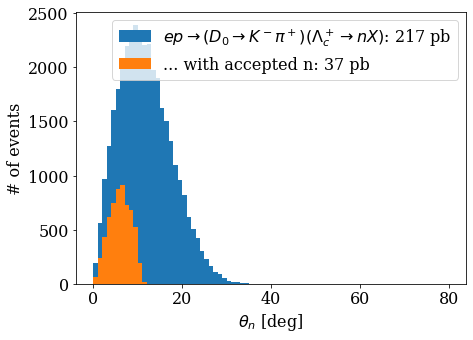

In [27]:
#neutron acceptance:
accepted = df.query(acceptance_condition("N") +" and Ntype==2112")
num = len(accepted)
denom = len(df.query("Ntype==2112"))
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))





label=f"$ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow n X)$: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_npi*1000:.0f} pb"
plt.hist(df.query("Ntype==2112").N_theta*180/np.pi,bins=np.linspace(0,80,81), label =label)
#plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted neutron\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")
plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"... with accepted n: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_npi*num/denom*1000:.0f} pb")


plt.legend()
plt.xlabel("$\\theta_n$ [deg]")
plt.ylabel("# of events")
plt.show()

0.1646658975398335 +- 0.0014644032701182038


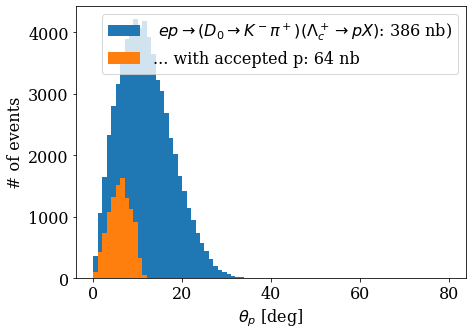

In [28]:
#proton acceptance:
accepted = df.query(acceptance_condition("N") +" and Ntype==2212")
num = len(accepted)
denom = len(df.query("Ntype==2212"))
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))

label =f" $ep\\rightarrow (D_0\\rightarrow K^-\\pi^+) (\\Lambda_c^+\\rightarrow p X)$: {tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_ppi*1000:.0f} nb)"
plt.hist(df.query("Ntype==2212").N_theta*180/np.pi,bins=np.linspace(0,80,81), label =label)
#plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted proton\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")
label=f"... with accepted p: {num/denom*tot_nb*f_D0_Kminus_piplus*f_lambdac_lambda*f_lambda_to_ppi*1000:.0f} nb"
plt.hist(accepted.N_theta*180/np.pi,bins=np.linspace(0, 80, 81), label =label)
plt.legend()
plt.xlabel("$\\theta_p$ [deg]")
plt.ylabel("# of events")
plt.show()

0.05682 +- 0.0007320620711387799
0.00219 +- 0.0001478243518504309
0.00364 +- 0.00019044028985485187


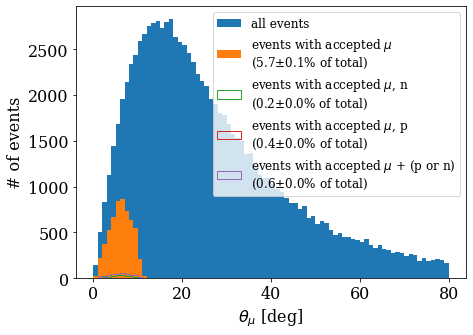

In [25]:
#plot events in which both the muon and the nucleon are within acceptance.
accepted_mu = df.query(acceptance_condition("mu"))
num = len(accepted_mu)
denom = len(df)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))

plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label ="all events")
plt.hist(accepted_mu.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted $\mu$\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")

accepted_mu_n = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N") + " and Ntype==2112")
num = len(accepted_mu_n)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))
plt.hist(accepted_mu_n.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$, n\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

accepted_mu_p = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N") + " and Ntype==2212")
num = len(accepted_mu_p)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))
plt.hist(accepted_mu_p.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$, p\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

accepted_mu_p_or_n = df.query(acceptance_condition("mu")+ " and "+ acceptance_condition("N"))
num = len(accepted_mu_p_or_n)

plt.hist(accepted_mu_p.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), 
         label=f"events with accepted $\mu$ + (p or n)\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)",
          histtype='step')

plt.legend(fontsize=12)
plt.xlabel("$\\theta_\mu$ [deg]")
plt.ylabel("# of events")
plt.show()

In [40]:
nb_tot=40

f_lamdba_c_mu = 0.035
f_lamdba_c_e = 0.036

print("sigma (mu+)=", nb_tot*f_lamdba_c_mu)
print("sigma (mu+, accepted)=", nb_tot*f_lamdba_c_mu*.116)
print("sigma (mu+, n, accepted)=", nb_tot*f_lamdba_c_mu*.007)
print("sigma (mu+, p, accepted)=", nb_tot*f_lamdba_c_mu*.012)
print("sigma (mu+, p or n, accepted)=", nb_tot*f_lamdba_c_mu*.019)

sigma (mu+)= 1.4000000000000001
sigma (mu+, accepted)= 0.16240000000000002
sigma (mu+, n, accepted)= 0.009800000000000001
sigma (mu+, p, accepted)= 0.016800000000000002
sigma (mu+, p or n, accepted)= 0.026600000000000002


In [42]:
def toLund(df, filename):
    with open(filename, "w") as f:
        for i in range(len(df)):
#             1 Number of particles
#             2 Mass number of the target (UD)
#             3 Atomic number oif the target (UD)
#             4 Target polarization (UD)
#             5 Beam Polarization
#             6 Beam type, electron=11, photon=22” (UD)
#             7 Beam energy (GeV) (UD)
#             8 Interacted nucleon ID (2212 or 2112) (UD)
#             9 Process ID (UD)
#             10 Event weight (UD)

            #for now just include the electron and the muon
            print(2, 1, 1,0, 0, 11,Ebeam,2212, 0, 1, file=f)
            for j,(particle_name, pid) in enumerate([("e", 11), ("mu", -13)]):
                particle = pdg.GetParticle(pid)
                print(j+1, particle.Lifetime()/1e9, 1, pid, 0,0, 
                      df[particle_name + "_"+"px"][i], 
                      df[particle_name + "_"+"py"][i],
                      df[particle_name + "_"+"pz"][i],
                      df[particle_name + "_"+"E"][i],
                      particle.Mass(), 0,0,0, file=f)

In [43]:
toLund(df, "100kemufromlambdac.dat")